# 資料準備

In [1]:
import time
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import data
#import dataset

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

# 設定參數

In [2]:
# Number of color channels for the images: 1 channel for gray-scale.
num_channels =1

# image dimensions (only squares for now)
img_size = 28

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
#classes = ['Brook','Clown','Gold','Soldier','White']
classes = ['0','1','2','3','4','5','6','7','8','9']
num_classes = len(classes)

# batch size
batchSize = 100

# validation split
validation_size = .15
testdation_size = .15

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

train_path = 'U:/git/fish_Recognition/mnist_png/training'
test_path = 'U:/git/fish_Recognition/mnist_png/testing'
checkpoint_dir = "./set_models/"

# 建立共用函數

In [3]:
#data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)
#test_data = dataset.read_test_set(test_path, img_size, classes, validation_size=0)
data = data.read_train_sets(train_path, img_size, classes, validation_size=validation_size,testdation_size=testdation_size)

Reading training images
Loading 0 files (Index: 0)
Loading 1 files (Index: 1)
Loading 2 files (Index: 2)
Loading 3 files (Index: 3)
Loading 4 files (Index: 4)
Loading 5 files (Index: 5)
Loading 6 files (Index: 6)
Loading 7 files (Index: 7)
Loading 8 files (Index: 8)
Loading 9 files (Index: 9)


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
#print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))
print("-Testdation-set:\t{}".format(len(data.test.labels)))

Size of:
- Training-set:		42000
- Validation-set:	9000
-Testdation-set:	9000


In [5]:
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1),
                       name ='W')

In [6]:
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape)
                       , name = 'b')

In [7]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], 
                        padding='SAME')

In [8]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], 
                          strides=[1,2,2,1], 
                          padding='SAME')

# 輸入層 Input Layer

In [9]:
with tf.name_scope('Input_Layer'):
    x = tf.placeholder("float",shape=[None, img_size_flat]
                       ,name="x")    
    x_image = tf.reshape(x, [-1, img_size, img_size,num_channels])

# Convolutional Layer 1

In [10]:
with tf.name_scope('C1_Conv'):
    W1 = weight([5,5,num_channels,16])
    b1 = bias([16])
    Conv1=conv2d(x_image, W1)+ b1
    C1_Conv = tf.nn.relu(Conv1 )

In [11]:
with tf.name_scope('C1_Pool'):
    C1_Pool = max_pool_2x2(C1_Conv)

# Convolutional Layer 2

In [12]:
with tf.name_scope('C2_Conv'):
    W2 = weight([5,5,16,36])
    b2 = bias([36])
    Conv2=conv2d(C1_Pool, W2)+ b2
    C2_Conv = tf.nn.relu(Conv2)

In [13]:
with tf.name_scope('C2_Pool'):
    C2_Pool = max_pool_2x2(C2_Conv) 

# Fully Connected Layer

In [14]:
with tf.name_scope('D_Flat'):
    layer_shape = C2_Pool.get_shape()
    num_features = layer_shape[1:4].num_elements()
    D_Flat = tf.reshape(C2_Pool, [-1, num_features])

In [15]:
with tf.name_scope('D_Hidden_Layer'):
    W3= weight([num_features, 128])
    b3= bias([128])
    D_Hidden = tf.nn.relu(
                  tf.matmul(D_Flat, W3)+b3)
    D_Hidden_Dropout= tf.nn.dropout(D_Hidden, 
                                keep_prob=0.7)

# 輸出層Output

In [16]:
with tf.name_scope('Output_Layer'):
    W4 = weight([128,num_classes])
    b4 = bias([num_classes])
    y_predict= tf.nn.softmax(
                 tf.matmul(D_Hidden_Dropout,
                           W4)+b4)

# 設定訓練模型最佳化步驟

In [17]:
with tf.name_scope("optimizer"):
    
    y_label = tf.placeholder("float", shape=[None, num_classes], 
                              name="y_label")
    
    loss_function = tf.reduce_mean(
                      tf.nn.softmax_cross_entropy_with_logits
                         (logits=y_predict , 
                          labels=y_label))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.00001) \
                    .minimize(loss_function)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# 設定評估模型

In [18]:
with tf.name_scope("evaluate_model"):
    correct_prediction = tf.equal(tf.argmax(y_predict, 1),
                                  tf.argmax(y_label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) # 非零為一，的平均差

# 訓練模型

In [19]:
trainEpochs = 100
train_batch_size = batchSize
valid_batch_size =  9000
totalBatchs = int(len(data.train.labels)/batchSize)
epoch_list=[];accuracy_list=[];loss_list=[];
from time import time
startTime=time()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [20]:
for epoch in range(trainEpochs):

    
    for i in range(totalBatchs):
        #batch_x, batch_y = mnist.train.next_batch(batchSize)
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        
        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]
        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        
        #sess.run(optimizer,feed_dict={x: batch_x, y_label: batch_y})
        sess.run(optimizer,feed_dict={x: x_batch, y_label: y_true_batch})
    x_valid_batch, y_vtrue_batch, _, valid_cls_batch = data.valid.next_batch(valid_batch_size)
    x_valid_batch = x_valid_batch.reshape(valid_batch_size, img_size_flat)
    loss,acc = sess.run([loss_function,accuracy],
                        feed_dict={x: x_valid_batch, 
                                   y_label: y_vtrue_batch})

    epoch_list.append(epoch)
    loss_list.append(loss);accuracy_list.append(acc)    
    
    print("Train Epoch:", '%02d' % (epoch+1), \
          "Loss=","{:.9f}".format(loss)," Accuracy=",acc)
    
duration =time()-startTime
print("Train Finished takes:",duration)         

Train Epoch: 01 Loss= 2.182258844  Accuracy= 0.34477776
Train Epoch: 02 Loss= 2.016752720  Accuracy= 0.519
Train Epoch: 03 Loss= 1.925380588  Accuracy= 0.59977776
Train Epoch: 04 Loss= 1.847987175  Accuracy= 0.66977775
Train Epoch: 05 Loss= 1.807622790  Accuracy= 0.6946667
Train Epoch: 06 Loss= 1.762772441  Accuracy= 0.7492222
Train Epoch: 07 Loss= 1.731927633  Accuracy= 0.77133334
Train Epoch: 08 Loss= 1.712656260  Accuracy= 0.7841111
Train Epoch: 09 Loss= 1.697084665  Accuracy= 0.79355556
Train Epoch: 10 Loss= 1.688365459  Accuracy= 0.798
Train Epoch: 11 Loss= 1.679765224  Accuracy= 0.8054444
Train Epoch: 12 Loss= 1.670454025  Accuracy= 0.81288886
Train Epoch: 13 Loss= 1.667023659  Accuracy= 0.8111111
Train Epoch: 14 Loss= 1.659948945  Accuracy= 0.818
Train Epoch: 15 Loss= 1.655574679  Accuracy= 0.82233334
Train Epoch: 16 Loss= 1.651106358  Accuracy= 0.825
Train Epoch: 17 Loss= 1.647611380  Accuracy= 0.8281111
Train Epoch: 18 Loss= 1.643717647  Accuracy= 0.831
Train Epoch: 19 Loss= 1

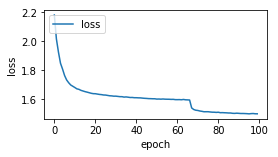

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list, loss_list, label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')

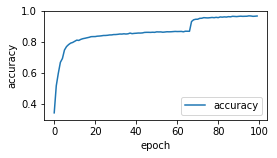

In [22]:
plt.plot(epoch_list, accuracy_list,label="accuracy" )
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.ylim(0.3,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


# 評估模型準確率

In [41]:
len(data.test.labels)

9000

In [23]:
test_size = 9000
x_test_batch, y_test_batch, _, test_cls_batch = data.test.next_batch(test_size)
x_test_batch = x_test_batch.reshape(test_size, img_size_flat)
print("Accuracy:", 
      sess.run(accuracy,feed_dict={x: x_test_batch,
                                   y_label: y_test_batch}))

Accuracy: 0.9667778


In [24]:
print("Accuracy:", 
      sess.run(accuracy,feed_dict={x: x_test_batch[:4500],
                                   y_label: y_test_batch[:4500]}))


Accuracy: 0.96577775


In [25]:
print("Accuracy:", 
      sess.run(accuracy,feed_dict={x:x_test_batch[4500:],
                                   y_label: y_test_batch[4500:]}))

Accuracy: 0.9662222


# 預測機率

In [26]:
y_predict=sess.run(y_predict, 
                   feed_dict={x: x_test_batch[:10]})

In [27]:
y_predict[:5]

array([[4.2875996e-07, 8.6289695e-09, 2.0192640e-06, 1.2591312e-08,
        1.6716203e-07, 5.9919851e-09, 1.1490635e-12, 9.9912602e-01,
        2.3220027e-06, 8.6916314e-04],
       [2.5586321e-04, 6.8899666e-05, 1.4016858e-06, 1.3171338e-06,
        7.7948040e-05, 4.3490318e-06, 1.0658136e-06, 1.4240404e-04,
        9.8844939e-01, 1.0997422e-02],
       [3.6171818e-07, 9.9960130e-01, 2.4218833e-05, 2.0903489e-08,
        2.0076653e-04, 2.4484893e-06, 1.3772189e-04, 4.1349854e-06,
        2.8919247e-05, 1.4134374e-09],
       [1.6387397e-14, 3.8094265e-15, 1.0000000e+00, 2.1519066e-10,
        1.7972870e-20, 5.8015644e-18, 2.7616364e-15, 1.7679805e-18,
        5.5741459e-16, 1.1446914e-16],
       [3.9941742e-08, 9.9951470e-01, 5.9346203e-05, 8.4165316e-07,
        1.4781358e-05, 1.0161296e-09, 3.2229926e-07, 3.7068181e-04,
        3.9214559e-05, 8.7661462e-08]], dtype=float32)

# 預測結果

In [28]:
prediction_result=sess.run(tf.argmax(y_predict,1),
                           feed_dict={x:x_test_batch ,
                                      y_label:y_test_batch})

In [29]:
prediction_result[:10]

array([7, 8, 1, 2, 1, 5, 2, 1, 6, 4], dtype=int64)

In [30]:
import numpy as np
def show_images_labels_predict(images,labels,prediction_result):
    fig = plt.gcf()
    fig.set_size_inches(8, 10)
    for i in range(0, 10):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(np.reshape(images[i],(28, 28)), 
                  cmap='binary')
        ax.set_title("label=" +str(np.argmax(labels[i]))+
                     ",predict="+str(prediction_result[i])
                     ,fontsize=9) 
    plt.show()

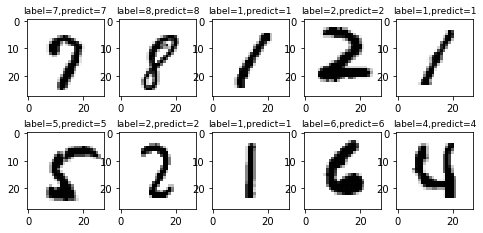

In [31]:
show_images_labels_predict(data.test.images,data.test.labels,prediction_result)

# 找出預測錯誤

In [33]:
for i in range(500):
    if prediction_result[i]!=np.argmax(mnist.test.labels[i]):
        print("i="+str(i)+
              "   label=",np.argmax(mnist.test.labels[i]),
              "predict=",prediction_result[i])

NameError: name 'mnist' is not defined

In [31]:
def show_images_labels_predict_error(images,labels,prediction_result):
    fig = plt.gcf()
    fig.set_size_inches(8, 10)
    i=0;j=0
    while i<10:
        if prediction_result[j]!=np.argmax(labels[j]):
            ax=plt.subplot(5,5, 1+i)
            ax.imshow(np.reshape(images[j],(28, 28)), 
                      cmap='binary')
            ax.set_title("j="+str(j)+
                         ",l=" +str(np.argmax(labels[j]))+
                         ",p="+str(prediction_result[j])
                         ,fontsize=9) 
            i=i+1  
        j=j+1
    plt.show()

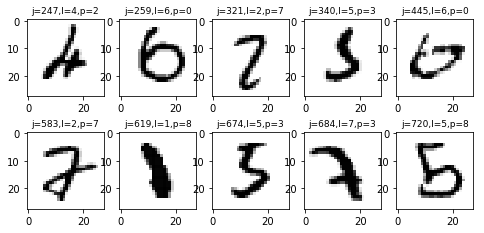

In [32]:
show_images_labels_predict_error(mnist.test.images,mnist.test.labels,prediction_result)

In [33]:
saver = tf.train.Saver()

In [34]:
save_path = saver.save(sess, "set_model/CNN")

In [35]:
print("Model saved in file: %s" % save_path)

Model saved in file: saveModel/CNN_model1


In [36]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('log/CNN',sess.graph)

In [37]:
#sess.close()